<a href="https://colab.research.google.com/github/Sauptik23/Identification-of-medicinal-plants/blob/main/Final_model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Installations

In [1]:
!pip install -q kaggle
!pip install -q opendatasets
!pip install split-folders

##Imports

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import opendatasets as od
from numpy.ma.core import true_divide
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import splitfolders
from keras.api._v2.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip,RandomRotation,RandomZoom,RandomHeight,RandomWidth
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.efficientnet import EfficientNetB3,EfficientNetB5,EfficientNetB2
from keras.layers import Flatten, Dense,Dropout,Input,Activation
from keras.layers import GlobalAveragePooling2D
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [3]:
od.download(
    "https://www.kaggle.com/datasets/aryashah2k/indian-medicinal-leaves-dataset"
    )

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sauptikmukherjee
Your Kaggle Key: ··········


100%|██████████| 9.00G/9.00G [01:34<00:00, 102MB/s]


#Inspecting the dataset

In [ ]:

for dirpath,dirnames,filenames in os.walk("Indian Medicinal Leaves Image Datasets"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'Indian Medicinal Leaves Image Datasets'.
There are 40 directories and 0 images in 'Indian Medicinal Leaves Image Datasets/Medicinal plant dataset'.
There are 0 directories and 146 images in 'Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Raktachandini'.
There are 0 directories and 152 images in 'Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Nagadali'.
There are 0 directories and 165 images in 'Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Hibiscus'.
There are 0 directories and 146 images in 'Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Wood_sorel'.
There are 0 directories and 146 images in 'Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Gauva'.
There are 0 directories and 187 images in 'Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Jasmine'.
There are 0 directories and 150 images in 'Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/

#View Random Image

In [ ]:
#view an image


def view_random_image(target_dir,target_class):
  target_folder=target_dir+target_class
  random_image=random.sample(os.listdir(target_folder),1)
  img=mpimg.imread(target_folder +"/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(img.shape)
  return img

#Creating train-test-valid split

In [4]:
path_leaves="/content/Medicinal Leaf dataset"
splitfolders.ratio(path_leaves,seed=1337, output="(Splitted)Indian Medicininal Leaves Dataset", ratio=(0.6, 0.2, 0.2))

Copying files: 6904 files [01:26, 79.87 files/s]


#Storing class names in class_names_leaves

In [5]:
import pathlib
import numpy as np
data_dir_leaves = pathlib.Path("/content/(Splitted)Indian Medicininal Leaves Dataset/train") # turn our training path into a Python path
class_names_leaves = np.array(sorted([item.name for item in data_dir_leaves.glob('*')])) # created a list of class_names from the subdirectories
print(class_names_leaves)

['Aloevera' 'Amla' 'Amruthaballi' 'Arali' 'Astma_weed' 'Badipala'
 'Balloon_Vine' 'Bamboo' 'Beans' 'Betel' 'Bhrami' 'Bringaraja'
 'Caricature' 'Castor' 'Catharanthus' 'Chakte' 'Chilly'
 'Citron lime (herelikai)' 'Coffee' 'Common rue(naagdalli)' 'Coriender'
 'Curry' 'Doddpathre' 'Drumstick' 'Ekka' 'Eucalyptus' 'Ganigale' 'Ganike'
 'Gasagase' 'Ginger' 'Globe Amarnath' 'Guava' 'Henna' 'Hibiscus' 'Honge'
 'Insulin' 'Jackfruit' 'Jasmine' 'Kambajala' 'Kasambruga' 'Kohlrabi'
 'Lantana' 'Lemon' 'Lemongrass' 'Malabar_Nut' 'Malabar_Spinach' 'Mango'
 'Marigold' 'Mint' 'Neem' 'Nelavembu' 'Nerale' 'Nooni' 'Onion' 'Padri'
 'Palak(Spinach)' 'Papaya' 'Parijatha' 'Pea' 'Pepper' 'Pomoegranate'
 'Pumpkin' 'Raddish' 'Rose' 'Sampige' 'Sapota' 'Seethaashoka' 'Seethapala'
 'Spinach1' 'Tamarind' 'Taro' 'Tecoma' 'Thumbe' 'Tomato' 'Tulsi'
 'Turmeric' 'ashoka' 'camphor' 'kamakasturi' 'kepala']


#Mounting the Google drive


In [40]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
len(class_names_leaves)

80

#Model Checkpoint

In [11]:
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0)

#Experiment 1

##Data augmentation using ImageDataGenerator

In [ ]:
from numpy.ma.core import true_divide
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   width_shift_range=0.2,
                                   zoom_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=0.2)
test_datagen = ImageDataGenerator(rescale=1/255.)
valid_datagen=ImageDataGenerator(rescale=1/255.)
train_dir="/content/(Splitted)Indian Medicininal Leaves Dataset/train"
test_dir="/content/(Splitted)Indian Medicininal Leaves Dataset/test"
valid_dir="/content/(Splitted)Indian Medicininal Leaves Dataset/val"

IMAGE_SHAPE=(600,450)
# Load data in from directories and turn it into batches
train_data_leaves = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=32,
                                               class_mode='categorical') # changed to categorical

test_data_leaves = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=32,
                                              class_mode='categorical')
valid_data_leaves=valid_datagen.flow_from_directory(valid_dir,
                                         target_size=IMAGE_SHAPE,
                                         batch_size=32,
                                         class_mode='categorical')

Found 4106 images belonging to 80 classes.
Found 1448 images belonging to 80 classes.
Found 1346 images belonging to 80 classes.


##Tensorboard callback

In [ ]:
import datetime
def create_tensorboard_callback(dir_name,experiment_name):
  log_dir=dir_name+"/" +experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback=tf.keras.callbacks.Tensorboard(
      log_dir=log_dir
  )
  print(f"Saving tensorboard log files to :{log_dir}")
  return tensorboard_callback

##Resnet_url

In [ ]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"


##Create_model

In [ ]:
def create_model(model_url, num_classes=80):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    Dropout(0.2),
    Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

##Compiling the model

In [ ]:
resnet_model = create_model(resnet_url, num_classes=80)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

##Fitting the model

In [ ]:

resnet_history = resnet_model.fit(train_data_leaves,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_leaves),
                                  validation_data=test_data_leaves,
                                  validation_steps=len(test_data_leaves),
                                  callbacks=[model_checkpoint]
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  )

Epoch 1/5


KeyboardInterrupt: ignored

##Evaluating the model

In [ ]:
resnet_model.evaluate(valid_data_leaves)

##Loading the weights

In [ ]:
resnet_model.load_weights(checkpoint_path)

##Loading the weights and retraining the model from epoch 5

In [ ]:
initial_epochs=resnet_history.epoch[-1]
epochs=initial_epochs+6
resnet_history_2=resnet_model.fit(train_data_leaves,
                                  epochs=epochs,
                                  initial_epoch=initial_epochs,
                                  steps_per_epoch=len(train_data_leaves),
                                  validation_data=valid_data_leaves,
                                  validation_steps=int(0.15*(len(valid_data_leaves))),
                                  callbacks=model_checkpoint)

##Plotting loss curves

In [38]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

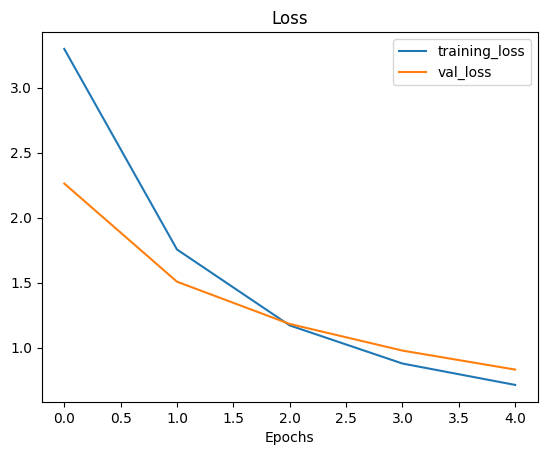

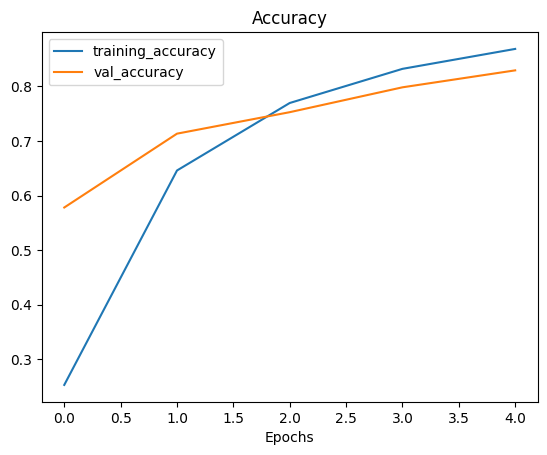

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
resnet_model.evaluate(test_data_leaves)

46/46 [==============================] - 153s 3s/step - loss: 0.5271 - accuracy: 0.8840


[0.5271270275115967, 0.8839778900146484]

##Loading and preprocessing the input image(load_and_prep_image)

In [ ]:
def load_and_prep_image(filename):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [600,450])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

##Predicting the plant and plotting the image

In [ ]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

##Using pickle to save the model

In [ ]:
import pickle
model_pkl="model91.pkl"
with open(model_pkl,"wb") as file:
  pickle.dump(resnet_model,file)

In [ ]:
with open(model_pkl,"rb") as file:
  model=pickle.load(file)

TypeError: ignored

##Saving the model in Gdrive

In [ ]:

path = f"/content/gdrive/My Drive/model(<91)"
resnet_model.save(path)

#Experiment 2

##Turning on mixed prescision

In [6]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

##Training the model without data augmentation

##Creating batches of images

In [7]:
train_dir="/content/(Splitted)Indian Medicininal Leaves Dataset/train"
test_dir="/content/(Splitted)Indian Medicininal Leaves Dataset/test"
valid_dir="/content/(Splitted)Indian Medicininal Leaves Dataset/val"
IMAGE_SIZE=(224,224)
BATCH_SIZE=32

In [8]:
train_data_leaves=image_dataset_from_directory(directory=train_dir,
                                               image_size=IMAGE_SIZE,
                                               label_mode="categorical",
                                               batch_size=BATCH_SIZE)
test_data_leaves=image_dataset_from_directory(directory=test_dir,
                                               image_size=IMAGE_SIZE,
                                               label_mode="categorical",
                                               batch_size=BATCH_SIZE)
val_data_leaves=image_dataset_from_directory(directory=valid_dir,
                                               image_size=IMAGE_SIZE,
                                               label_mode="categorical",
                                               batch_size=BATCH_SIZE)

Found 4106 files belonging to 80 classes.
Found 1448 files belonging to 80 classes.
Found 1346 files belonging to 80 classes.


##Creating the model

In [21]:

def create_model():
  # Create base model
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.resnet50.ResNet50(include_top=False)
  base_model.trainable = False # freeze base model layers

  # Create Functional model
  inputs = layers.Input(shape=input_shape, name="input_layer")


  x = base_model(inputs, training=False)
  x = GlobalAveragePooling2D(name="pooling_layer")(x)
  x = Dense(len(class_names_leaves))(x)
  outputs = Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  resnet50_model = tf.keras.Model(inputs, outputs)
  return resnet50_model

resnet50_model1=create_model()
# Compile the model
resnet50_model1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [12]:
resnet50_model_history= resnet50_model1.fit(train_data_leaves,
                                            epochs=5,
                                            steps_per_epoch=len(train_data_leaves),
                                            validation_data=test_data_leaves,
                                            validation_steps=int(0.15 * len(test_data_leaves)),
                                            callbacks=model_checkpoint)

Epoch 1/5
129/129 [==============================] - 154s 1s/step - loss: 2.5044 - accuracy: 0.4323 - val_loss: 1.2882 - val_accuracy: 0.6771
Epoch 2/5
129/129 [==============================] - 139s 1s/step - loss: 0.7302 - accuracy: 0.8427 - val_loss: 0.8735 - val_accuracy: 0.7708
Epoch 3/5
129/129 [==============================] - 140s 1s/step - loss: 0.3828 - accuracy: 0.9408 - val_loss: 0.7869 - val_accuracy: 0.7917
Epoch 4/5
129/129 [==============================] - 139s 1s/step - loss: 0.2323 - accuracy: 0.9720 - val_loss: 0.6566 - val_accuracy: 0.8229
Epoch 5/5
129/129 [==============================] - 145s 1s/step - loss: 0.1534 - accuracy: 0.9883 - val_loss: 0.5318 - val_accuracy: 0.8698


##Augmenting the data

In [14]:
data_augmentation=Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomHeight(0.2),
    RandomZoom(0.2),
    RandomWidth(0.2),
])

In [33]:
def create_model_augmented_data():
  # Create base model
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.resnet50.ResNet50(include_top=False)
  base_model.trainable = False # freeze base model layers

  # Create Functional model
  inputs = layers.Input(shape=input_shape, name="input_layer")

  x=data_augmentation(inputs)
  x = base_model(inputs, training=False)
  x = GlobalAveragePooling2D(name="pooling_layer")(x)
  x=Dropout(0.2)(x)
  x = Dense(len(class_names_leaves))(x)
  outputs = Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  resnet50_model = tf.keras.Model(inputs, outputs)
  return resnet50_model


In [34]:
model2=create_model_augmented_data()

In [35]:
model2.load_weights(checkpoint_path)

In [36]:
model2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [37]:
model2_history=model2.fit(train_data_leaves,
                          epochs=5,
                          steps_per_epoch=len(train_data_leaves),
                          validation_data=test_data_leaves,
                          validation_steps=len(val_data_leaves),
                          callbacks=model_checkpoint)

Epoch 1/5
129/129 [==============================] - 164s 1s/step - loss: 0.1778 - accuracy: 0.9735 - val_loss: 0.5911 - val_accuracy: 0.8387
Epoch 2/5
129/129 [==============================] - 181s 1s/step - loss: 0.1344 - accuracy: 0.9825 - val_loss: 0.5580 - val_accuracy: 0.8445
Epoch 3/5
129/129 [==============================] - 183s 1s/step - loss: 0.1069 - accuracy: 0.9873 - val_loss: 0.5164 - val_accuracy: 0.8641
Epoch 4/5
129/129 [==============================] - 224s 2s/step - loss: 0.0832 - accuracy: 0.9910 - val_loss: 0.5179 - val_accuracy: 0.8605
Epoch 5/5
129/129 [==============================] - 219s 2s/step - loss: 0.0667 - accuracy: 0.9951 - val_loss: 0.5035 - val_accuracy: 0.8685


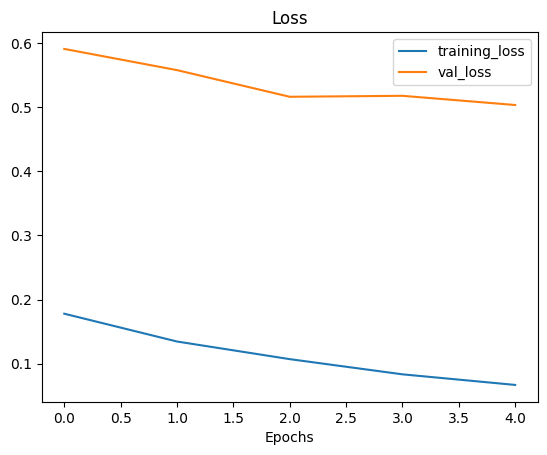

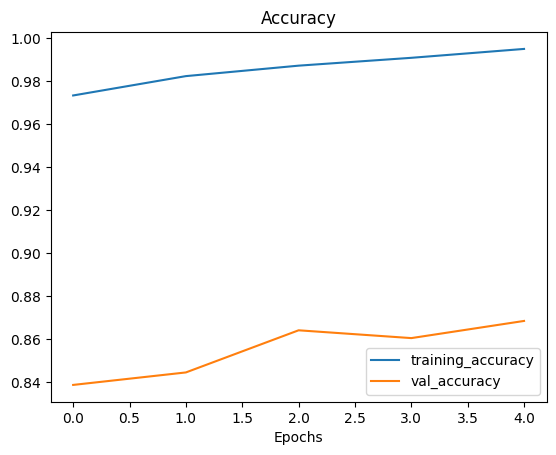

In [39]:
plot_loss_curves(model2_history)

In [42]:
import pickle
model_pkl="model98.pkl"
with open(model_pkl,"wb") as file:
  pickle.dump(model2,file)

In [43]:
with open(model_pkl,"rb") as file:
  model=pickle.load(file)

In [44]:
model.evaluate(test_data_leaves)

46/46 [==============================] - 39s 673ms/step - loss: 0.5075 - accuracy: 0.8667


[0.5075256824493408, 0.8667126893997192]